In [ ]:
import torch
from torch import nn
from torch import optim
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 101)

In [ ]:
import pandas as pd

df = pd.DataFrame({"X1":X[:,0],
                   "X2":X[:,1],
                   "label": y})
df

,X1,X2,label
0,0.676218,0.497584,1
1,-0.812723,-0.543010,0
2,0.192605,1.020086,0
3,-0.320621,-0.691720,1
4,-0.779619,0.645467,0
...,...,...,...
995,0.423747,0.586634,1
996,-0.347300,-0.692031,1
997,-0.463515,-0.870102,0
998,0.740357,0.223233,1


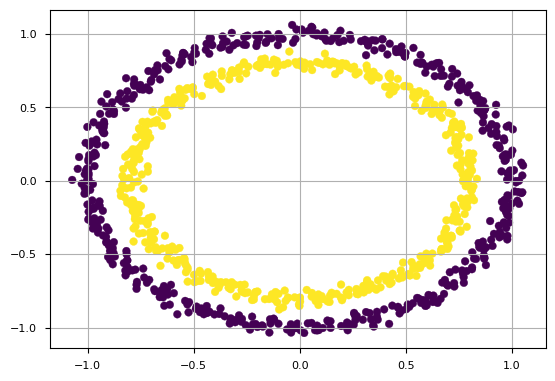

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-paper")

plt.scatter(df["X1"],df["X2"],c=y)
plt.grid(True)

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)
X_train_gpu,X_test_gpu,y_train_gpu,y_test_gpu = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)


In [ ]:
y_train_gpu = y_train_gpu.reshape(shape=[800,1])
y_test_gpu = y_test_gpu.reshape(shape=[200,1])

In [ ]:
class Cmodel (nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features = 2 , out_features = 5)
    self.layer2 = nn.Linear(in_features = 5 , out_features = 5 )
    self.layer3 = nn.Linear(in_features = 5, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self,x):
    z = self.layer1(x)
    z = self.relu(z)
    z = self.layer2(z)
    z = self.relu(z)
    z = self.layer3(z)
    return z

In [ ]:
model_0 = Cmodel().to(device)
model_1 = Cmodel().to(device)


In [ ]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.2672, -0.4662],
                      [ 0.3783,  0.4282],
                      [ 0.1490,  0.2593],
                      [-0.6477,  0.6389],
                      [-0.3428,  0.2690]])),
             ('layer1.bias',
              tensor([ 0.3876, -0.4304,  0.3202,  0.7041,  0.1738])),
             ('layer2.weight',
              tensor([[-0.0234, -0.1757, -0.2474, -0.2740, -0.4126],
                      [ 0.4226,  0.0660,  0.1169, -0.3004,  0.2018],
                      [-0.2318,  0.0269, -0.3645, -0.0772, -0.2923],
                      [ 0.2852,  0.2140, -0.3676,  0.3621, -0.2434],
                      [-0.0333, -0.0939,  0.1424,  0.4104,  0.0630]])),
             ('layer2.bias',
              tensor([ 0.0286,  0.0854, -0.2142, -0.0328, -0.1803])),
             ('layer3.weight',
              tensor([[-0.3526,  0.3162, -0.1067,  0.0578, -0.1548]])),
             ('layer3.bias', tensor([0.1088]))])

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(params = model_1.parameters(), lr = 0.1)

In [ ]:
def accuracy(y_pred,y_test):
  correct = torch.eq(y_pred,y_test).sum().item()
  acc = round(correct/len(y_pred)*100)
  return acc

In [ ]:
# Training loop

epoch = 101

epoch_count = []
train_loss = []
test_loss_l = []
accuracy_train_l =[]
accuracy_test_l = []


for epochs in range(epoch):

  model_1.train()
  y_pred_logits = model_1(X_train_gpu)
  y_pred = torch.round(torch.sigmoid(model_1(X_train_gpu))) # logits -> pred prob -> labels
  # Training loss
  loss = loss_fn(y_pred_logits,y_train_gpu)
  acc_train = accuracy(y_pred,y_train_gpu)
  opt.zero_grad()
  loss.backward()
  opt.step()

  model_1.eval()

  with torch.inference_mode():
    y_pred_test_logits = model_1(X_test_gpu)
    y_pred_test = torch.round(torch.sigmoid(model_1(X_test_gpu)))
    test_loss = loss_fn(y_pred_test_logits,y_test_gpu)
    acc_test = accuracy(y_pred_test,y_test_gpu)

  if epochs % 10 == 0:
    epoch_count.append(epochs)
    train_loss.append(loss.item())
    test_loss_l.append(test_loss.item())
    accuracy_train_l.append(acc_train)
    accuracy_test_l.append(acc_test)
    print(f"Epoch {epochs} | Training loss {loss} | Training accuracy {acc_train}% | Test loss {test_loss} | Test accuracy {acc_test}%")



Epoch 0 | Training loss 0.6960256695747375 | Training accuracy 50% | Test loss 0.6949130892753601 | Test accuracy 44%
Epoch 10 | Training loss 0.6671085357666016 | Training accuracy 56% | Test loss 0.6561946868896484 | Test accuracy 57%
Epoch 20 | Training loss 0.5109961032867432 | Training accuracy 80% | Test loss 0.5381758213043213 | Test accuracy 80%
Epoch 30 | Training loss 0.3603522777557373 | Training accuracy 87% | Test loss 0.3880315124988556 | Test accuracy 85%
Epoch 40 | Training loss 0.1281021684408188 | Training accuracy 98% | Test loss 0.11282676458358765 | Test accuracy 99%
Epoch 50 | Training loss 0.0519133061170578 | Training accuracy 100% | Test loss 0.07019499689340591 | Test accuracy 98%
Epoch 60 | Training loss 0.02449915185570717 | Training accuracy 100% | Test loss 0.030240094289183617 | Test accuracy 99%
Epoch 70 | Training loss 0.015524202957749367 | Training accuracy 100% | Test loss 0.02717396803200245 | Test accuracy 99%
Epoch 80 | Training loss 0.01212762109

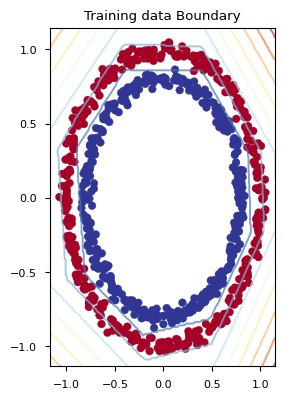

In [ ]:
import seaborn as sns
def plot_decisionBoundary(model,X_train,y_train,X_test,y_test):
  plt.subplot(121)

  plt.title("Training data Boundary")
  x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:,0].max() + 0.1
  y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1

  X,y = np.meshgrid(np.linspace(x_min,x_max,100),np.linspace(y_min,y_max,100))

  x_in = np.c_[X.ravel(),y.ravel()]

  model.train()

  y_pred = model(torch.from_numpy(x_in).type(torch.float))

  y_pred =  y_pred.detach().numpy()

  y_pred = np.round(y_pred).reshape(X.shape)

  plt.xlim(X.min(), X.max())
  plt.ylim(y.min(), y.max())

  plt.contour(X,y,y_pred,cmap=plt.cm.RdYlBu,alpha=0.7)

  plt.scatter(X_train[:,0],X_train[:,1], c = y_train,cmap=plt.cm.RdYlBu )

plot_decisionBoundary(model_1,X_train,y_train,X_test,y_test)

tensor([ 0.2097,  0.3721,  0.7115, -0.3625,  0.7750,  0.6079, -0.4250, -0.3472,
         0.5074, -0.6120])